In [42]:
import os
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.ops import sample_points_from_meshes
from minimal.solver import Solver
from minimal import armatures
from minimal.models import KinematicModel, KinematicPCAWrapper
import numpy as np
import minimal.config as config
from dataloader.result_loader import KinectResultLoader
from minimal.bridge import JointsBridge

from tqdm.notebook import tqdm
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

from dataloader.utils import ymdhms_time

%load_ext autoreload
%autoreload 2

np.random.seed(20160923)
scale = 0.5

def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.auto_scale_xyz(x, y)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# pose_glb = np.zeros([1, 3]) # global rotation


########################## smpl settings ##########################
# note that in smpl and smpl-h no pca for pose is provided
# therefore in the model we fake an identity matrix as the pca coefficients
# to make the code compatible

n_pose = 23 * 3 # degrees of freedom, (n_joints - 1) * 3
# smpl 1.0.0: 10
# smpl 1.1.0: 300
# n_shape = 10
# TODO: Read pose from skeleton
k_loader = KinectResultLoader('./ignoredata/minimal_files/input/')
files = k_loader.select_by_id(200)
kinect_skeleton = np.load(files["kinect/master/skeleton"]["filepath"])

bridge = JointsBridge()
bridge.load_kinect_joints(kinect_skeleton[0])
bridge.kinect_joints_transfer_coordinates()
keypoints_gt = bridge.update_smpl_joints_from_kinect_joints()
keypoints_gt = bridge.normalization(keypoints_gt)

Loading .png from ./ignoredata/minimal_files/input/kinect/master/color
Loading .png from ./ignoredata/minimal_files/input/kinect/master/depth
Loading .npy from ./ignoredata/minimal_files/input/kinect/master/skeleton


In [44]:
# pose_pca = np.random.uniform(-0.2, 0.2, size=n_pose)
# shape = np.random.normal(size=n_shape)
mesh = KinematicModel(config.SMPL_MODEL_1_0_PATH, armatures.SMPLArmature, scale=scale)

########################## solving example ############################

wrapper = KinematicPCAWrapper(mesh, n_pose=n_pose)
solver = Solver(verbose=True, max_iter=int(10e7))

# mesh_gt, keypoints_gt = \
# mesh.set_params(pose_pca=pose_pca, pose_glb=pose_glb, shape=shape)
# pointcloud_gt = Pointclouds(sample_points_from_meshes(mesh_gt, num_samples=1000))
pointcloud_gt = None
params_est = solver.solve(wrapper, pointcloud_gt, keypoints_gt, v=5)

shape_est, pose_pca_est, pose_glb_est = wrapper.decode(params_est)

# print('----------------------------------------------------------------------')
# print('ground truth parameters')
# print('pose pca coefficients:', pose_pca)
# print('pose global rotation:', pose_glb)
# print('shape: pca coefficients:', shape)

print('----------------------------------------------------------------------')
print('estimated parameters')
print('pose pca coefficients:', pose_pca_est)
print('pose global rotation:', pose_glb_est)
print('shape: pca coefficients:', shape_est)

# mesh.set_params(pose_pca=pose_pca)
# mesh.show_obj('gt')
# mesh.save_obj(os.path.join(config.SAVE_PATH, './gt.obj'))
mesh.set_params(pose_pca=pose_pca_est)
mesh.show_obj('est')
mesh.save_obj(os.path.join(config.SAVE_PATH, './scale={}_esttm={}.obj'.format(scale, ymdhms_time())))

print('ground truth and estimated meshes are saved into gt.obj and est.obj')


[2021-08-10_18-04-33] : idx=0	period=0.7689332962036133	loss=12.537585035782236	loss_kpts=12.537585035782236	loss_edge=0.0	loss_face=0.0
[2021-08-10_18-04-34] : idx=1	period=0.7720136642456055	loss=0.09153345885974175	loss_kpts=0.09153345885974175	loss_edge=0.0	loss_face=0.0
[2021-08-10_18-04-34] : idx=2	period=0.77303147315979	loss=0.09556504104899873	loss_kpts=0.09556504104899873	loss_edge=0.0	loss_face=0.0
[2021-08-10_18-04-35] : idx=3	period=0.7724273204803467	loss=0.11947834074152049	loss_kpts=0.11947834074152049	loss_edge=0.0	loss_face=0.0
[2021-08-10_18-04-36] : idx=4	period=0.7716174125671387	loss=0.09616657668008669	loss_kpts=0.09616657668008669	loss_edge=0.0	loss_face=0.0
[2021-08-10_18-04-37] : idx=5	period=0.7733321189880371	loss=0.0770632046978815	loss_kpts=0.0770632046978815	loss_edge=0.0	loss_face=0.0
[2021-08-10_18-04-37] : idx=6	period=0.7726092338562012	loss=0.10596677558346808	loss_kpts=0.10596677558346808	loss_edge=0.0	loss_face=0.0
[2021-08-10_18-04-38] : idx=7	per

Text(0.5, 1.0, 'Loss vs iterations')

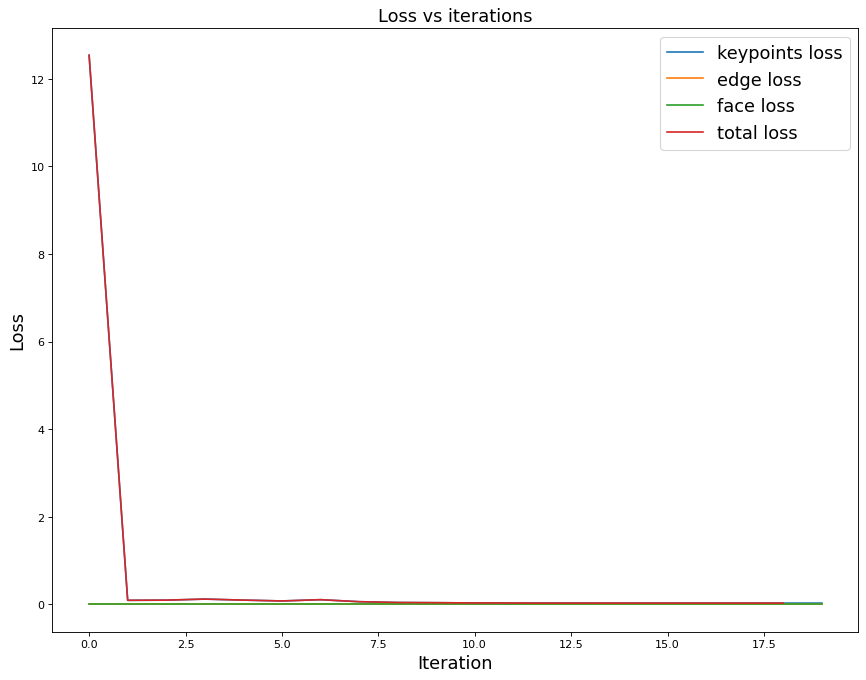

In [45]:
fig = plt.figure(figsize=(13, 10))
ax = fig.gca()
ax.plot(solver.kpts_losses, label="keypoints loss")
ax.plot(solver.edge_losses, label="edge loss")
ax.plot(solver.face_losses, label="face loss")
ax.plot(solver.losses, label="total loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")